In [20]:
import WNQuery
import os
import sys
from wnxmlconsole import write_synset
from pprint import pformat, pprint
import networkx as nx
import matplotlib.pyplot as plt
from operator import attrgetter, itemgetter
from itertools import chain


In [2]:
wn = WNQuery.WNQuery("plwordnet-3.1-visdisc.xml", open(os.devnull, "w"))
wn.writeStats(sys.stderr)

PoS		#synsets	#word senses	#words
Nouns		132398		176779		134778
Verbs		27693		38564		19595
Adjectives	11256		14035		8006
Adverbs		0		0		0


## Wszystkie znaczenia słowa szkoda i ich synonimy

In [3]:
szkoda_synset = wn.lookUpLiteral('szkoda', 'n')
for x in szkoda_synset:
    id = x.wnid
    write_synset(x, sys.stdout)
    synonymIds = wn.lookUpRelation(id, 'n', 'bliskoznaczność')
    print("synonimy:")
    for y in synonymIds:
        write_synset(wn.lookUpID(y, 'n'), sys.stdout)
    print("---------\n")

PLWN-00003675-n  {strata:1, utrata:1, szkoda:2, uszczerbek:1}  ()
synonimy:
PLWN-00078375-n  {szwank:1, niekorzyść:1}  ()
---------

PLWN-00006533-n  {szkoda:1}  (brak danych)
synonimy:
---------



In [4]:
from itertools import tee, islice


def window(it, size=3):
    yield from zip(
        *[islice(it, s, None) for s, it in enumerate(tee(it, size))])

In [7]:
def synset_string(syns):
    buff = []
    for i in syns.synonyms:
        buff.append("{0}".format(i.literal))
    return "  {{{0}}}  ({1})".format(", ".join(buff), syns.definition)

### Hiperonimia `wypadek drogowy`

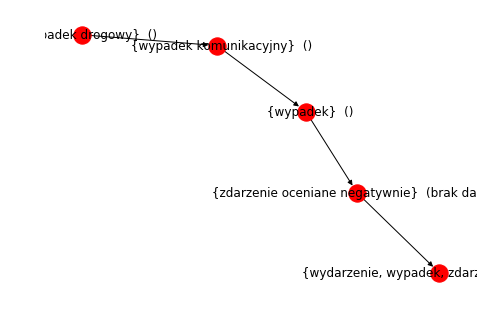

In [8]:
wypadek = wn.lookUpLiteral('wypadek drogowy', 'n')[0]
hypernym_ids = wn.traceRelationD(wypadek.wnid, 'n', 'hypernym')
nodes = map(lambda h: synset_string(wn.lookUpID(h[0], 'n')), hypernym_ids)
node_list = list(nodes)

G = nx.DiGraph()
edges = window(node_list, 2)
for e in edges:
    G.add_edge(e[0], e[1])
pos = nx.layout.spring_layout(G)
nx.draw(G, with_labels=True)

In [9]:
meanigs = map(lambda h: wn.lookUpID(h[0], 'n'), hypernym_ids)
list(meanigs)

In [10]:
wn.traceRelation('PLWN-00000323-n', 'n', 'hypernym')
wn.traceRelation('PLWN-00036467-n', 'n', 'hypernym')
wn.traceRelation('PLWN-00102819-n', 'n', 'hypernym')

['PLWN-00102819-n', 'PLWN-00027419-n', 'PLWN-00006526-n']

## Bezpośrednie hiponimy `wypadek_1`

In [12]:
wypadek1 = wn.lookUpLiteral('szkoda', 'n')[0].wnid
wypadek_hiponyms = wn.traceRelationD(wypadek1, 'n', 'hyponym')

for x in filter(lambda tup: tup[1] == 1, wypadek_hiponyms):
    synset = wn.lookUpID(x[0], 'n')
    write_synset(synset, sys.stdout)

PLWN-00001439-n  {krzywda:1, niesprawiedliwość:1}  (brak danych)
PLWN-00046769-n  {uszczerbek na zdrowiu:1}  ()
PLWN-00235767-n  {frycowe:1, gapowe:1}  ()
PLWN-00235773-n  {przegrana:2}  ()
PLWN-00239437-n  {depersonalizacja:1}  ()
PLWN-00393729-n  {zgar:1}  ()
PLWN-00404031-n  {dekulturacja:1}  ()
PLWN-00411013-n  {straty moralne:1}  ()
PLWN-00419137-n  {trójkąt Harbergera:1}  ()
PLWN-00472552-n  {szkoda majątkowa:1}  ()


## hiponimy 2 rzędu dla `wypadek_2`

In [13]:
for x in filter(lambda tup: tup[1] == 2, wypadek_hiponyms):
    synset = wn.lookUpID(x[0], 'n')
    write_synset(synset, sys.stdout)

PLWN-00011033-n  {represja:1, ucisk:1, prześladowanie:2, terror:1}  ()
PLWN-00013469-n  {nietolerancja:1, nietolerancyjność:1}  ()
PLWN-00013551-n  {wyzysk:1}  ()
PLWN-00018350-n  {nierówność:2}  ()
PLWN-07062071-n  {autodestrukcja:2, samodestrukcja:2, samozagłada:2, samozniszczenie:2, samounicestwienie:2}  ()


In [61]:
wn.lookUpSense('szkoda', 2, 'n')
words = [('szkoda', 2), ('strata', 1), ('uszczerbek', 1),
         ('szkoda majątkowa', 1), ('uszczerbek na zdrowiu', 1), ('krzywda', 1),
         ('niesprawiedliwość', 1), ('nieszczęście', 2)]
synsets = list(map(lambda tup: wn.lookUpSense(tup[0], tup[1], 'n'), words))
word_map = dict(
    zip(map(attrgetter('wnid'), synsets), map(itemgetter(0), words)))


def filter_relations(synset):
    synset_ids = list(map(attrgetter('wnid'), synsets))
    filtered = filter(lambda tup: tup[0] in synset_ids, synset.ilrs)
    return list(map(lambda x: (synset.wnid, *x), filtered))


edges = list(set(chain.from_iterable(map(filter_relations, synsets))))
relation_color = {'hiponimia': 'r', 'hyponym': 'r', 'hypernym': 'g'}

G = nx.DiGraph()
for e in edges:
    G.add_edge(e[0], e[1])
    G[e[0]][e[1]]['color'] = relation_color[e[2]]

pos = nx.layout.spring_layout(G)

G.edges[edges[0][0],edges[0][1]]['color']
edges

[('PLWN-00003675-n', 'PLWN-00472552-n', 'hyponym'),
 ('PLWN-00472552-n', 'PLWN-00003675-n', 'hypernym'),
 ('PLWN-00003675-n', 'PLWN-00001439-n', 'hyponym'),
 ('PLWN-00003675-n', 'PLWN-00046769-n', 'hyponym'),
 ('PLWN-00001439-n', 'PLWN-00005640-n', 'hypernym'),
 ('PLWN-00005640-n', 'PLWN-00001439-n', 'hyponym'),
 ('PLWN-00005640-n', 'PLWN-00001439-n', 'hiponimia'),
 ('PLWN-00003675-n', 'PLWN-00001439-n', 'hiponimia'),
 ('PLWN-00003675-n', 'PLWN-00046769-n', 'hiponimia'),
 ('PLWN-00046769-n', 'PLWN-00003675-n', 'hypernym'),
 ('PLWN-00003675-n', 'PLWN-00472552-n', 'hiponimia'),
 ('PLWN-00001439-n', 'PLWN-00003675-n', 'hypernym')]

In [63]:
 %matplotlib notebook
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import numpy as np

def draw_network(G,pos,ax,sg=None):
    
    for n in G:
        c=Circle(pos[n],radius=0.2)
        ax.add_patch(c)
        G.node[n]['patch']=c
        x,y=pos[n]
        
        ax.text( x, y, word_map[n])
    seen={}
    for (u,v,d) in G.edges(data='color', default='purple'):
        n1=G.node[u]['patch']
        n2=G.node[v]['patch']
        print(d)
        rad=0.1
        if (u,v) in seen:
            rad=seen.get((u,v))
            rad=(rad+np.sign(rad)*0.1)*-1
        alpha=0.5
        e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
                            arrowstyle='-|>',
                            connectionstyle='arc3,rad=%s'%rad,
                            mutation_scale=10.0,
                            lw=2,
                            alpha=alpha,
                            color=d)
        seen[(u,v)]=rad
        ax.add_patch(e)
    return e



pos=nx.spring_layout(G)
ax=plt.gca()
draw_network(G,pos,ax)
ax.autoscale()
plt.axis('equal')
plt.axis('off')
plt.savefig("graph.pdf")
plt.show()
pos

<IPython.core.display.Javascript object>

r
r
r
g
g
g
g
r


{'PLWN-00001439-n': array([-0.02274149, -0.43514675]),
 'PLWN-00003675-n': array([0.01380083, 0.23102583]),
 'PLWN-00005640-n': array([-0.05621865, -1.        ]),
 'PLWN-00046769-n': array([-0.41088246,  0.62374249]),
 'PLWN-00472552-n': array([0.47604178, 0.58037843])}